# QuickTuneTool - A Demo


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/automl/QTT/blob/main/notebooks/demo.ipynb)

This guide will show you how to:

* Install `quicktunetool`,
* Use our meta-trained surrogate and start a run,
* Load and test a fine-tuned model for inference

## Install QTT and dependencies

In [1]:
!pip install git+https://github.com/automl/QTT

  Cloning https://github.com/automl/QTT (to revision demo) to /tmp/pip-req-build-r3adxr2_
  Running command git clone --filter=blob:none --quiet https://github.com/automl/QTT /tmp/pip-req-build-r3adxr2_
  Running command git checkout -b demo --track origin/demo
  Switched to a new branch 'demo'
  Branch 'demo' set up to track remote branch 'demo' from 'origin'.
  Resolved https://github.com/automl/QTT to commit 4f5b05fe8133362a96463002d6e8f2cd1b38b1d1
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 53.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.1/274.1 kB 35.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 78.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.6/175.6 kB 14.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 M

## Download image dataset

To demonstrate the use of QTT, we will use the Imagenette dataset. Considering the limited hardware available on Colab, we will use only a small subset of the images.

- for *training* only 40 samples per class are used
- the validation set is split in *val* and *test*
- 10 samples per class for val
- 5 samples per class for test


In [2]:
#@title download-script
%%capture
!wget https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-320.tgz
!tar -xzvf imagenette2-320.tgz

import os
import shutil

def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def copy_files(src_dir, dest_dir, start_idx, end_idx):
    files = sorted(os.listdir(src_dir))
    total_files = len(files)
    if start_idx >= 0 and end_idx < total_files:
        for i in range(start_idx, end_idx + 1):
            shutil.copy(os.path.join(src_dir, files[i]), dest_dir)

# Create necessary directories
create_dir('dataset/train')
create_dir('dataset/val')
create_dir('dataset/test')

# Process training set
train_dir = 'imagenette2-320/train'
for class_name in os.listdir(train_dir):
    class_dir = os.path.join(train_dir, class_name)
    if os.path.isdir(class_dir):
        create_dir(os.path.join('dataset/train', class_name))
        copy_files(class_dir, os.path.join('dataset/train', class_name), 0, 39)

# Process validation set
val_dir = 'imagenette2-320/val'
for class_name in os.listdir(val_dir):
    class_dir = os.path.join(val_dir, class_name)
    if os.path.isdir(class_dir):
        create_dir(os.path.join('dataset/val', class_name))
        create_dir(os.path.join('dataset/test', class_name))

        total_files = len(os.listdir(class_dir))

        # Copy first 20 images to validation set
        copy_files(class_dir, os.path.join('dataset/val', class_name), 0, 19)

        # Copy last 5 images to test set
        copy_files(class_dir, os.path.join('dataset/test', class_name), total_files - 5, total_files - 1)


## Setup

We utilize our predefined search space; however, similar to the image dataset, we adapt the hyperparameters to accommodate the limited hardware. We restrict the models to a maximum of 10 million parameters and reduce the maximum batch size to 32.

In [3]:
from ConfigSpace.read_and_write import json as cs_json
from qtt.configuration import ConfigManager
from qtt.factory import get_optimizer
from qtt.tuners import QuickTuner
from qtt.finetune.cv.classification import finetune_script

In [4]:
# @title Define search-space
space = """
{
  "hyperparameters": [
    {
      "name": "amp",
      "type": "ordinal",
      "sequence": [
        false,
        true
      ],
      "default": false
    },
    {
      "name": "batch_size",
      "type": "ordinal",
      "sequence": [
        2,
        4,
        8,
        16,
        32
      ],
      "default": 2
    },
    {
      "name": "bss_reg",
      "type": "ordinal",
      "sequence": [
        0.0,
        0.0001,
        0.001,
        0.01,
        0.1
      ],
      "default": 0.0
    },
    {
      "name": "clip_grad",
      "type": "ordinal",
      "sequence": [
        0,
        1,
        10
      ],
      "default": 0
    },
    {
      "name": "cotuning_reg",
      "type": "ordinal",
      "sequence": [
        0.0,
        0.5,
        1.0,
        2.0,
        4.0
      ],
      "default": 0.0
    },
    {
      "name": "cutmix",
      "type": "ordinal",
      "sequence": [
        0.0,
        0.1,
        0.25,
        0.5,
        1,
        2,
        4
      ],
      "default": 0.0
    },
    {
      "name": "data_augmentation",
      "type": "categorical",
      "choices": [
        "auto_augment",
        "random_augment",
        "trivial_augment",
        "no_augment"
      ],
      "default": "no_augment",
      "weights": null
    },
    {
      "name": "delta_reg",
      "type": "ordinal",
      "sequence": [
        0.0,
        0.0001,
        0.001,
        0.01,
        0.1
      ],
      "default": 0.0
    },
    {
      "name": "drop",
      "type": "ordinal",
      "sequence": [
        0.0,
        0.1,
        0.2,
        0.3,
        0.4
      ],
      "default": 0.0
    },
    {
      "name": "epochs",
      "type": "constant",
      "value": 50
    },
    {
      "name": "layer_decay",
      "type": "ordinal",
      "sequence": [
        0.0,
        0.65,
        0.75
      ],
      "default": 0.0
    },
    {
      "name": "linear_probing",
      "type": "ordinal",
      "sequence": [
        false,
        true
      ],
      "default": false
    },
    {
      "name": "lr",
      "type": "ordinal",
      "sequence": [
        1e-05,
        5e-05,
        0.0001,
        0.0005,
        0.001,
        0.005,
        0.01
      ],
      "default": 1e-05
    },
    {
      "name": "mixup",
      "type": "ordinal",
      "sequence": [
        0.0,
        0.2,
        0.4,
        1.0,
        2.0,
        4.0,
        8.0
      ],
      "default": 0.0
    },
    {
      "name": "mixup_prob",
      "type": "ordinal",
      "sequence": [
        0.0,
        0.25,
        0.5,
        0.75,
        1.0
      ],
      "default": 0.0
    },
    {
      "name": "model",
      "type": "categorical",
      "choices": [
        "edgenext_small",
        "mobilevitv2_075",
        "edgenext_x_small",
        "mobilevit_xs",
        "edgenext_xx_small",
        "mobilevit_xxs",
        "dla46x_c"
      ],
      "default": "edgenext_small",
      "weights": null
    },
    {
      "name": "opt",
      "type": "categorical",
      "choices": [
        "sgd",
        "momentum",
        "adam",
        "adamw",
        "adamp"
      ],
      "default": "sgd",
      "weights": null
    },
    {
      "name": "pct_to_freeze",
      "type": "ordinal",
      "sequence": [
        0.0,
        0.2,
        0.4,
        0.6,
        0.8,
        1.0
      ],
      "default": 0.0
    },
    {
      "name": "sched",
      "type": "categorical",
      "choices": [
        "cosine",
        "step",
        "multistep",
        "plateau"
      ],
      "default": "cosine",
      "weights": null
    },
    {
      "name": "smoothing",
      "type": "ordinal",
      "sequence": [
        0.0,
        0.05,
        0.1
      ],
      "default": 0.0
    },
    {
      "name": "sp_reg",
      "type": "ordinal",
      "sequence": [
        0.0,
        0.0001,
        0.001,
        0.01,
        0.1
      ],
      "default": 0.0
    },
    {
      "name": "stoch_norm",
      "type": "ordinal",
      "sequence": [
        false,
        true
      ],
      "default": false
    },
    {
      "name": "warmup_epochs",
      "type": "ordinal",
      "sequence": [
        0,
        5,
        10
      ],
      "default": 0
    },
    {
      "name": "warmup_lr",
      "type": "ordinal",
      "sequence": [
        0.0,
        1e-05,
        1e-06
      ],
      "default": 0.0
    },
    {
      "name": "weight_decay",
      "type": "ordinal",
      "sequence": [
        0.1,
        0.01,
        0.001,
        1e-05,
        0.0001,
        0
      ],
      "default": 0.1
    },
    {
      "name": "auto_augment",
      "type": "categorical",
      "choices": [
        "v0",
        "original"
      ],
      "default": "v0",
      "weights": null
    },
    {
      "name": "decay_epochs",
      "type": "ordinal",
      "sequence": [
        10,
        20
      ],
      "default": 10
    },
    {
      "name": "decay_rate",
      "type": "ordinal",
      "sequence": [
        0.1,
        0.5
      ],
      "default": 0.1
    },
    {
      "name": "momentum",
      "type": "ordinal",
      "sequence": [
        0.0,
        0.8,
        0.9,
        0.95,
        0.99
      ],
      "default": 0.0
    },
    {
      "name": "opt_betas",
      "type": "categorical",
      "choices": [
        "(0.9, 0.999)",
        "(0.0, 0.99)",
        "(0.9, 0.99)",
        "(0.0, 0.999)"
      ],
      "default": "(0.9, 0.999)",
      "weights": null
    },
    {
      "name": "patience_epochs",
      "type": "ordinal",
      "sequence": [
        2,
        5,
        10
      ],
      "default": 2
    },
    {
      "name": "ra_magnitude",
      "type": "ordinal",
      "sequence": [
        8,
        9,
        17
      ],
      "default": 9
    },
    {
      "name": "ra_num_ops",
      "type": "ordinal",
      "sequence": [
        2,
        3
      ],
      "default": 2
    }
  ],
  "conditions": [
    {
      "child": "auto_augment",
      "parent": "data_augmentation",
      "type": "EQ",
      "value": "auto_augment"
    },
    {
      "child": "ra_magnitude",
      "parent": "data_augmentation",
      "type": "EQ",
      "value": "random_augment"
    },
    {
      "child": "ra_num_ops",
      "parent": "data_augmentation",
      "type": "EQ",
      "value": "random_augment"
    },
    {
      "child": "momentum",
      "parent": "opt",
      "type": "EQ",
      "value": "momentum"
    },
    {
      "child": "opt_betas",
      "type": "OR",
      "conditions": [
        {
          "child": "opt_betas",
          "parent": "opt",
          "type": "EQ",
          "value": "adam"
        },
        {
          "child": "opt_betas",
          "parent": "opt",
          "type": "EQ",
          "value": "adamw"
        },
        {
          "child": "opt_betas",
          "parent": "opt",
          "type": "EQ",
          "value": "adamp"
        }
      ]
    },
    {
      "child": "decay_epochs",
      "type": "OR",
      "conditions": [
        {
          "child": "decay_epochs",
          "parent": "sched",
          "type": "EQ",
          "value": "step"
        },
        {
          "child": "decay_epochs",
          "parent": "sched",
          "type": "EQ",
          "value": "multistep"
        }
      ]
    },
    {
      "child": "decay_rate",
      "type": "OR",
      "conditions": [
        {
          "child": "decay_rate",
          "parent": "sched",
          "type": "EQ",
          "value": "step"
        },
        {
          "child": "decay_rate",
          "parent": "sched",
          "type": "EQ",
          "value": "multistep"
        }
      ]
    },
    {
      "child": "patience_epochs",
      "parent": "sched",
      "type": "EQ",
      "value": "plateau"
    }
  ],
  "forbiddens": [],
  "python_module_version": "0.6.1",
  "json_format_version": 0.4
}
"""

### Load meta-trained surrogate model

In [5]:
import torch
from qtt.utils import extract_image_dataset_metadata

opt = get_optimizer("mtlbm/micro")

config_space = cs_json.read(space)
opt.cm.cs = config_space
opt.metafeatures = torch.tensor(
    extract_image_dataset_metadata("dataset").to_numpy(), dtype=torch.float
)

## Run QuickTune
Specify the path to the dataset and a time limit.

In [ ]:
qt = QuickTuner(opt, finetune_script)
task_info = {
    "data_path": "dataset",
    "train-split": "train",
    "val-split": "val",
    "num-classes": 10,
}
qt.run(task_info=task_info, time_budget=600)

config, score, cost, config_id = qt.get_incumbent()

## Load fine-tuned model

We now load the fine-tuned model and test the performance on unseen data.

In [7]:
import numpy as np
import torch
from timm.models import create_model
from torchvision import datasets
from torchvision import transforms as tf


def clean_state_dict(state_dict):
    state_dict = {k.replace("model._model.", ""): v for k, v in state_dict.items()}
    return state_dict


checkpoint_path =  qt.output_path + f"/{config_id}/model_best.pth.tar.pth" 
# load checkpoint
checkpoint = torch.load(checkpoint_path, map_location="cpu")
state_dict = checkpoint["state_dict"]
state_dict = clean_state_dict(state_dict)

model_name = config["model"]
model = create_model(model_name, pretrained=False, num_classes=10)
model.load_state_dict(state_dict, strict=False)
model.eval()
model.to("cuda")

transform = tf.Compose(
    [
        tf.Resize(256),
        tf.CenterCrop(224),
        tf.ToTensor(),
        tf.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)
data_path = "dataset/test"
dataset = datasets.ImageFolder(data_path)

images = []
labels = []
for _ in range(8):
    i = np.random.randint(len(dataset))
    img, label = dataset[i]
    images.append(img)
    labels.append(label)

input = torch.stack([transform(img) for img in images])
input = input.cuda()
with torch.no_grad():
    output = model(input)
    output = output.softmax(-1)
    _, indices = output.topk(1)

indices = indices.cpu().numpy().squeeze()

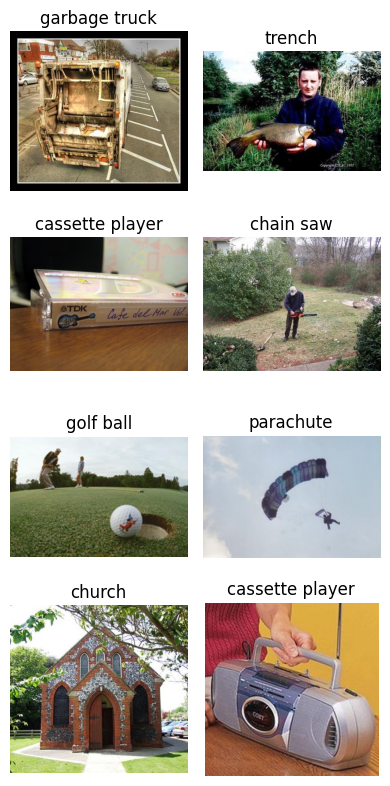

In [8]:
import matplotlib.pyplot as plt

classes = ["trench", "english springer", "cassette player", "chain saw", "church",
          "french horn", "garbage truck", "gas pump", "golf ball", "parachute"]

# Define a function to display a list of PIL images
def display_images(images, nrows=4, titles=None):
    n_images = len(images)
    if titles is None:
      titles = [''] * n_images
    fig = plt.figure(figsize=(4, 8))

    for n, (image, title) in enumerate(zip(images, titles)):
        ax = fig.add_subplot(nrows, int(n_images / nrows), n + 1)
        ax.imshow(image)
        ax.set_title(title)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

titles = [classes[i] for i in indices]
display_images(images, titles=titles)